# INFO284 Group assignment 
Kandidatnumre: 220, 177, 152



Introduksjon:
 
Datasettet vi har blitt tildelt "albums_all.csv" er et datsett bestående av info og egenskaper om 2833 ulike musikkalbum. Vi har også fått tildelt en mappe med 2833 .png bilder for album coverene til disse albumene. Målet med oppgavene er i første del å bruke albums_all.csv datasettet til å gjette popularity på album basert på de andre egenskapene, med bruk av 4 ulike regresjonsmodeller. 
Andre del består av en CNN, som får inn bildene av album coverene. Med bruk av dette skal den gjette 4 egenskaper i datasettet, 3 vi har valgt pluss popularity. Mer forklaring kommer på de ulike delene. 

# Imports

In [1]:

#Alle imports nødvendige for oppgaven:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
random_state = 567
albums = pd.read_csv('albums_all.csv')

# Preprocessing

In [2]:
albums.head()

name      id release_date  \
0                    "Fragtime" Theme Song "Fragile"   22352         2000   
1                               "Green n' gold Hits"  106534   2011-09-16   
2  "Zuhause Live: Das Laune der Natour-Finale" pl...   23608   2019-03-29   
3                                             #Gsnls    8655   2020-08-02   
4                                       #Hektarparty   49670   2018-09-21   

                                             artists  total_tracks  \
0  Moritani Misuzu (CV:Miku Ito), Murakami Haruka...             4   
1                 C.W.A. Cheeseheads With Attitude,             12   
2                                  Die Toten Hosen,             59   
3                                           Surf'n,              8   
4                                  Die Draufgänger,             17   

                                             t_name0  \
0                                            Fragile   
1           "Packer Face" (Everybody Vince Lombardi)   
2  Laune der Natur - das Intro - Live in Düsseldo...   
3                                        Lock'n Legs   
4                                 Die Hektar hat 2.0   

                               t_name1  \
0                            11:00a.m.   
1      "I Love Green Bay" (Player Mix)   
2  Opel-Gang - Live in Düsseldorf 2018   
3                      Capt'n Saven Em   
4                         Johnny Deere   

                                   t_name2  t_dur0    t_dur1  ...  t_val0  \
0                   Fragile - Instrumental  292720  293760.0  ...   0.330   
1                       "Beer Wit Da Bret"  213760  181000.0  ...   0.965   
2  Auswärtsspiel - Live in Düsseldorf 2018  157124  130446.0  ...   0.579   
3                           Bloods & Crips  127896  176351.0  ...   0.624   
4     Gina Lisa (Spiel mit deinen Glocken)  210320  226253.0  ...   0.840   

   t_val1  t_val2  t_tempo0  t_tempo1  t_tempo2  t_sig0  t_sig1  t_sig2  \
0  0.5390  0.1920    84.008   187.910    84.002     4.0     3.0     4.0   
1  0.7830  0.3770   119.032   128.002   181.241     4.0     4.0     4.0   
2  0.0475  0.0945    84.010   127.755    99.284     4.0     4.0     4.0   
3  0.3840  0.6510   100.053    99.999    95.017     4.0     4.0     4.0   
4  0.6650  0.5200   128.041   132.013   135.969     4.0     4.0     4.0   

   popularity  
0          21  
1          14  
2          41  
3           1  
4          47  

[5 rows x 45 columns]

In [3]:
albums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833 entries, 0 to 2832
Data columns (total 45 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          2833 non-null   object 
 1   id            2833 non-null   int64  
 2   release_date  2833 non-null   object 
 3   artists       2833 non-null   object 
 4   total_tracks  2833 non-null   int64  
 5   t_name0       2833 non-null   object 
 6   t_name1       2833 non-null   object 
 7   t_name2       2833 non-null   object 
 8   t_dur0        2833 non-null   int64  
 9   t_dur1        2833 non-null   float64
 10  t_dur2        2833 non-null   float64
 11  t_dance0      2833 non-null   float64
 12  t_dance1      2833 non-null   float64
 13  t_dance2      2833 non-null   float64
 14  t_energy0     2833 non-null   float64
 15  t_energy1     2833 non-null   float64
 16  t_energy2     2833 non-null   float64
 17  t_key0        2833 non-null   float64
 18  t_key1        2833 non-null 

In [4]:
albums.shape

(2833, 45)

In [5]:
albums = albums.drop(['name','id','artists', 't_name0', 't_name1', 't_name2'], axis=1)

Vi har valgt å fjerne alle verdiene med string, mest fordi vi tror features som navn på albumet og navn på sangene ikke vil ha noen stor betydning for populariteten på albumet, samtidig som det vil være vanskelig å samenligne disse string verdiene med de andre string verdiene i datasettet.
Vi tror at artists kunne vært en veldig god pekepin på popularitet, men siden det er et lite dataset med mange unike artister vil det ikke fungere noe bra på dette datasettet.

In [6]:
count = 0
for i in albums.release_date:
    if not isinstance(i, int):
        albums['release_date'].at[count] = int(i[:4])
    else:
        albums['release_date'].at[count] = int(i)
    count+=1


I release_date kan vi se at noe er skrevet som tall med bare årstallet, mens andre er skrevet som string med hele datoen. Derfor har vi laget dette skriptet for å sørge for at alle verdiene er int og kun er årstallet. 

<AxesSubplot:>

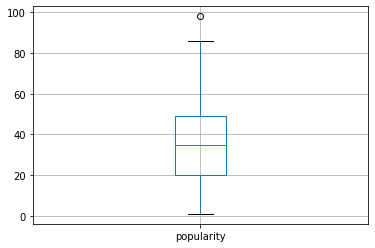

In [7]:
albums.boxplot("popularity")

Vi ser på boxplottet over at vi har nøyaktig en outlier. Å fjerne kun en rad vil ha lite effekt, så vi prøver å finne bedre informasjon om dette. 

In [8]:
#Plot hentet fra: https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/
import plotly.express as px
fig = px.histogram(albums, x="popularity")
fig.show()

Fra histogrammet over får vi et bedre bilde av spredningen av popularity i datasettet. Med skikkelig outlier-utregning fant vi kun en outlier, derfor har vi manuelt valgt å fjerne alle radene som har popularity over 75. Vi tror at dette kan forårsake skjevhet for modellene, så vi behandler dem som outliers og fjerner dem under. 

In [9]:
albums = albums.drop(albums[albums.popularity > 75].index)

Fjerner radene med popularity verdier over 75

In [10]:
fig = px.histogram(albums, x="popularity")
fig.show()

Plot for å vise den nye spredningen av popularity

In [11]:
albums2 = albums.copy()

In [12]:
albums2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2811 entries, 0 to 2832
Data columns (total 39 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   release_date  2811 non-null   object 
 1   total_tracks  2811 non-null   int64  
 2   t_dur0        2811 non-null   int64  
 3   t_dur1        2811 non-null   float64
 4   t_dur2        2811 non-null   float64
 5   t_dance0      2811 non-null   float64
 6   t_dance1      2811 non-null   float64
 7   t_dance2      2811 non-null   float64
 8   t_energy0     2811 non-null   float64
 9   t_energy1     2811 non-null   float64
 10  t_energy2     2811 non-null   float64
 11  t_key0        2811 non-null   float64
 12  t_key1        2811 non-null   float64
 13  t_key2        2811 non-null   float64
 14  t_mode0       2811 non-null   float64
 15  t_mode1       2811 non-null   float64
 16  t_mode2       2811 non-null   float64
 17  t_speech0     2811 non-null   float64
 18  t_speech1     2811 non-null 

Vi velger å lage to dataset; Et som beholder de meste av de originale features, og et album 2 som går gjennom alle t_ verdiene i albums og slår de sammen med gjennomsnittet. Alle features som er t_...0, 1 og 2 snakker om den første andre og tredje sangen i albumet. Derfor tenkte vi at et gjennomsnitt av disse 3 ville gi et bedre bilde for hele albumet. 

In [13]:
for i in range(2, 37, 3):
  col = albums2.columns[i]
  col2 = albums2.columns[i+1]
  col3 = albums2.columns[i+2]
  colname = col[2:-1]
  albums2[colname] = (albums2[albums2.columns[i]] + albums2[albums2.columns[i+1]] + albums2[albums2.columns[i+2]]) / 3




Lager de nye kolonnene med gjennomsnitt fra gamle verdier

In [14]:
for i in albums2:
  if(i[:2] == 't_'):
    albums2.drop(i, axis=1, inplace=True)

Fjerner de gamle t_... kolonnene.

In [15]:
X, y = albums.drop('popularity', axis = 1), albums.popularity
X2, y2 = albums2.drop('popularity', axis = 1), albums.popularity

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = random_state)

Splitter dataen i Test og Train, skiller mellom X_train og X_train2. 2 versjonen er med de kombinerte egenskaper. Vi setter ingen verdi til test_size, så den forblir på 0.25.

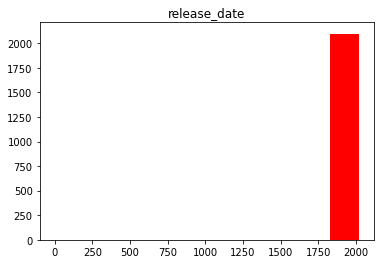

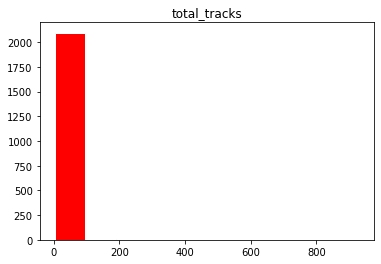

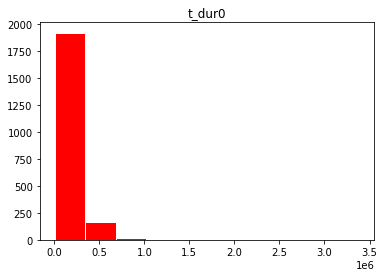

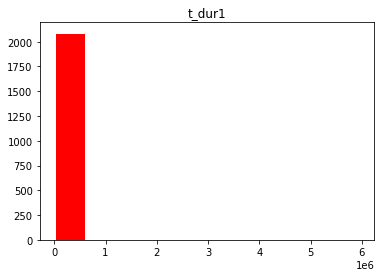

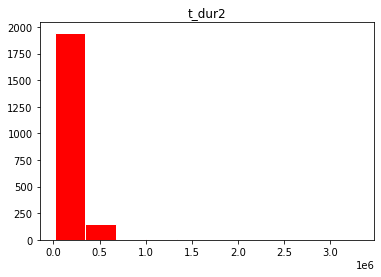

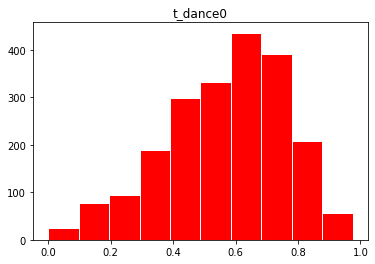

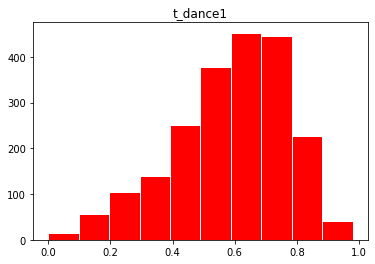

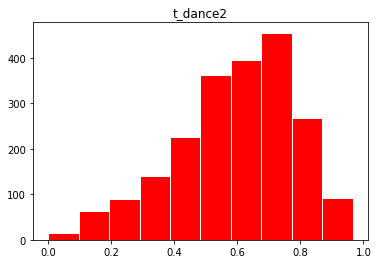

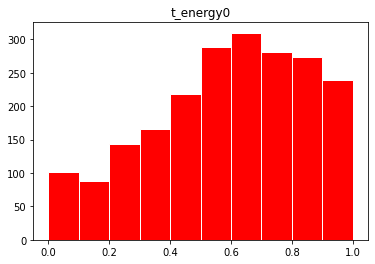

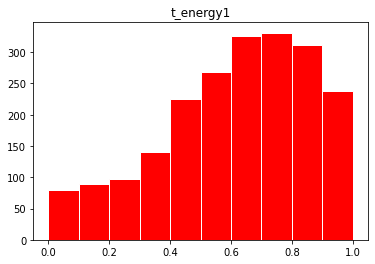

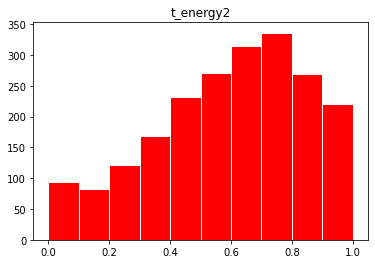

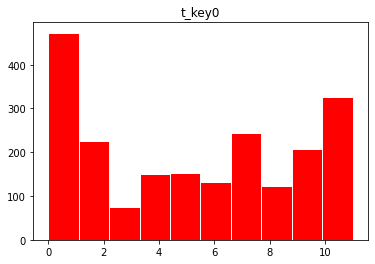

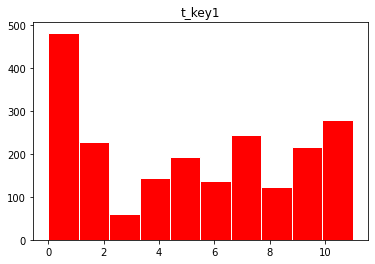

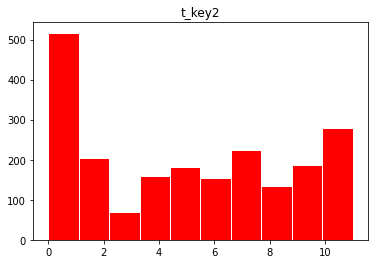

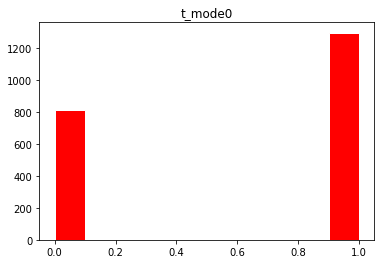

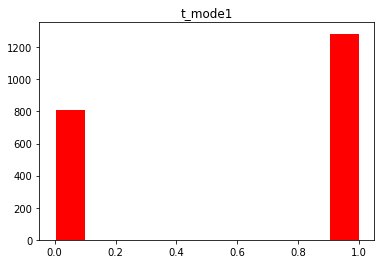

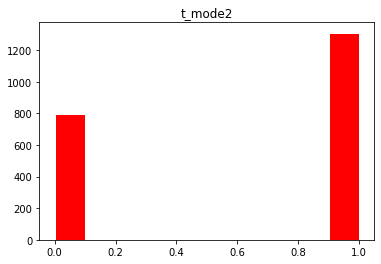

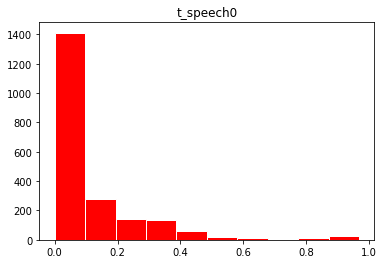

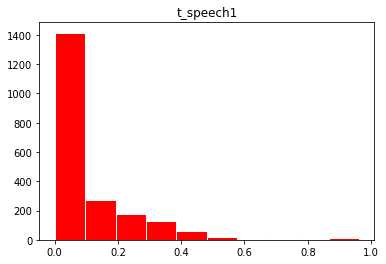

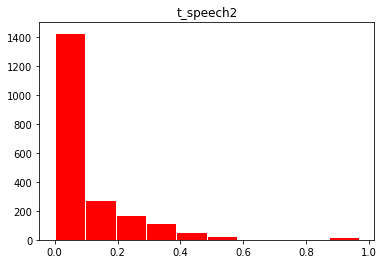

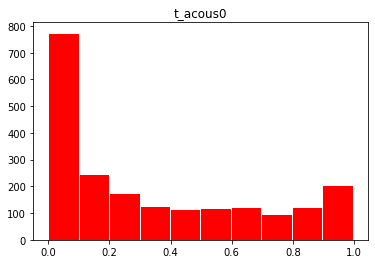

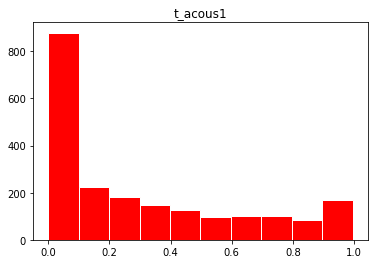

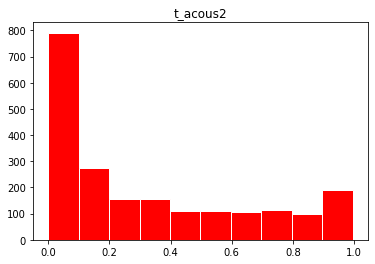

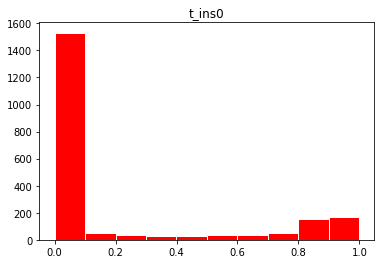

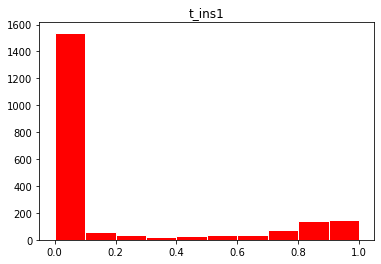

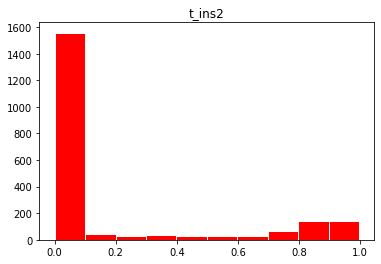

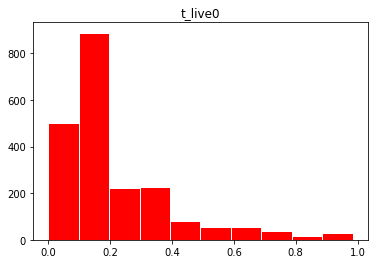

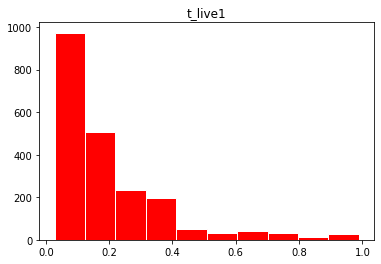

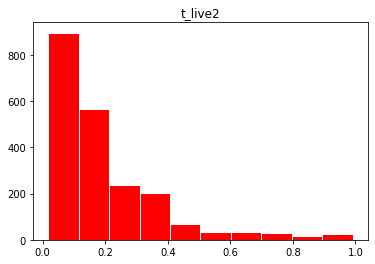

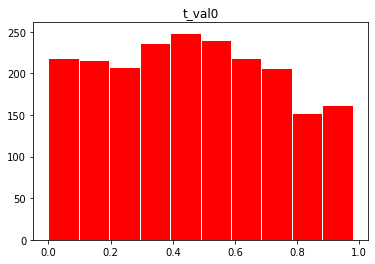

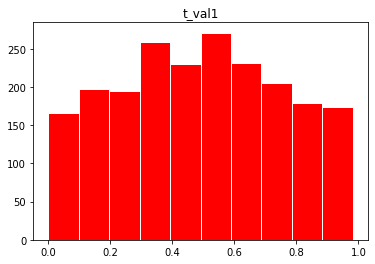

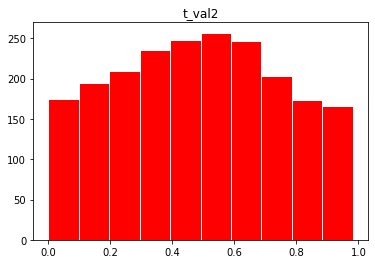

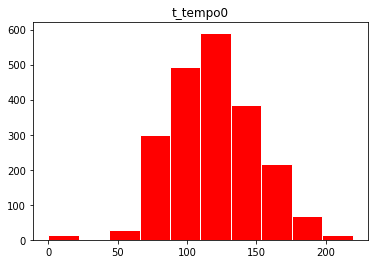

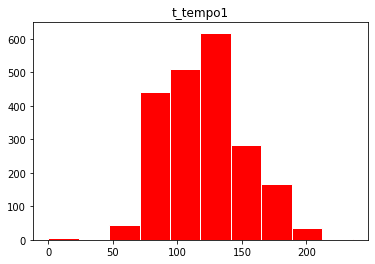

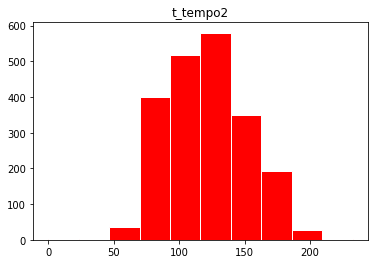

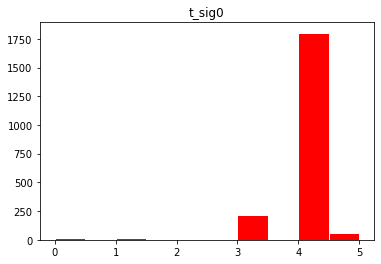

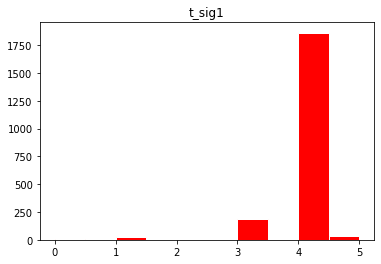

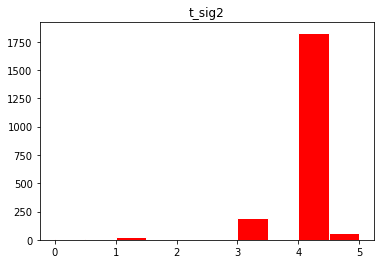

In [17]:
for i in X_train.keys():
    plt.hist(X_train[i], facecolor='red', edgecolor='white', bins=10)
    plt.title(i)
    plt.show()

Plot for å se hvor godt spredd ut dataene er, vi ser noen felt er godt spredt ut mens andre er mer ujevnt, derfor kan det være lurt å scale dataene, som vi gjør under.

In [18]:
X_train = preprocessing.scale(X_train, with_mean=True, with_std=True)
X_test = preprocessing.scale(X_test, with_mean=True, with_std=True)
X_train2 = preprocessing.scale(X_train2, with_mean=True, with_std=True)
X_test2 = preprocessing.scale(X_test2, with_mean=True, with_std=True)

Nokså enkel preprocessing. Vi ender opp med to set av X_train, X_test, y_train og y_test, et som beholder de fleste av de originale egenskapene, og et hvor mange av de er slått sammen til nye egenskaper. Noen maskinlæringsmodeller fungerer bedre med mange egenskaper og noen fungerer bedre med få, derfor er det greit å teste de med begge datasettene. 

Vi har også valgt å bruke en enkel scaler fra sklearn preprocessing for å skalere dataen, dette for å normalisere dataen, og gjør det lettere for modellene å lese og forstå dataen. En av modellene vi bruker (Random Forest), og andre tre-baserte modeller får ingen effekt av skalering og normalisering, men vi synes det var mest oversiktlig å ha skaleringen i preprocessingen så vi har valgt å bruke det før vi kjører noen av modellene. 

# Support vector machine

In [19]:
svm = SVR()
start = time.time()
svm.fit(X_train, y_train)
stop = time.time()
svmtime = stop-start
print("Training set score: {:.4f}".format(svm.score(X_train, y_train)))
print("Test set score: {:.4f}".format(svm.score(X_test, y_test)))
print("Time: {:.3f}".format(svmtime))

Training set score: 0.1480
Test set score: 0.1252
Time: 0.364


In [20]:
svm2 = SVR()
start = time.time()
svm2.fit(X_train2, y_train2)
stop = time.time()
svm2time = stop-start
print("Training 2 set score: {:.4f}".format(svm2.score(X_train2, y_train2)))
print("Test set 2 score: {:.4f}".format(svm2.score(X_test2, y_test2)))
print("Time: {:.3f}".format(svmtime))

Training 2 set score: 0.1478
Test set 2 score: 0.1483
Time: 0.364


Scoren som blir gitt her er r2 scoren, hvor 1 er helt perfekt gjett. Her ser vi at datasettet med de nye egenskapene presterer noe bedre (Kan variere litt per kjøring). Ser også at training set scoren er noe høyere en test set scoren, men ikke mye, ingen stor overfitting her.

In [21]:
print("MSE:", mean_squared_error(y_test2, svm2.predict(X_test2)))
print("RMSE:", math.sqrt(mean_squared_error(y_test2, svm2.predict(X_test2))))

MSE: 287.9843399455631
RMSE: 16.970101353426358


RMSE(Root mean squared error) verdien forteller oss hvor langt ifra hvert gjett er fra den faktiske verdien i gjennomsnitt. Jo nærmere null jo bedre.

In [22]:
param_grid = [{'kernel': ['rbf'], 
               'C': [0.001, 0.1, 10, 100], 
               'gamma': [0.001, 0.1, 10, 100]}, 
              {'kernel': ['poly'], 
               'C': [0.001, 0.1, 10, 100], 
               'gamma': [0.001, 0.1, 10, 100]}]

grid_search = GridSearchCV(SVR(), param_grid, cv=3)
grid_search.fit(X_train, y_train)
print(f"Best paramaters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best paramaters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.09394921747046896


Tester ut både poly og rbf som kernel, ettersom jeg tror disse er de som vil være best. Ideelt sett ville jeg testet ut alle kernelsene, med alle verdier 0.001, 0.01, 0.1, 1, 10, 100 på både C og gamma, men dette ville tatt utrolig lang tid å teste så derfor har jeg kortet ned parameterlisten litt. Denne kan fortsatt ta litt tid å kjøre.

In [23]:
svm = SVR(kernel=grid_search.best_params_.get('kernel'), C=grid_search.best_params_.get('C'), gamma=grid_search.best_params_.get('gamma'))
start = time.time()
svm.fit(X_train, y_train)
stop = time.time()
svmtime = stop-start
rmse = np.sqrt(svm.score(X_test, y_test))
print("Training set score: {:.4f}".format(svm.score(X_train, y_train)))
print("Test set score: {:.4f}".format(svm.score(X_test, y_test)))
print("RMSE Score: {:.4f}".format(rmse))
print("Time: {:.3f}".format(svmtime))

Training set score: 0.6462
Test set score: 0.1212
RMSE Score: 0.3482
Time: 0.373


Kjører en runde med de beste parameterene gitt i cross-validation, og regner ut tid og RMSE score for dette. 

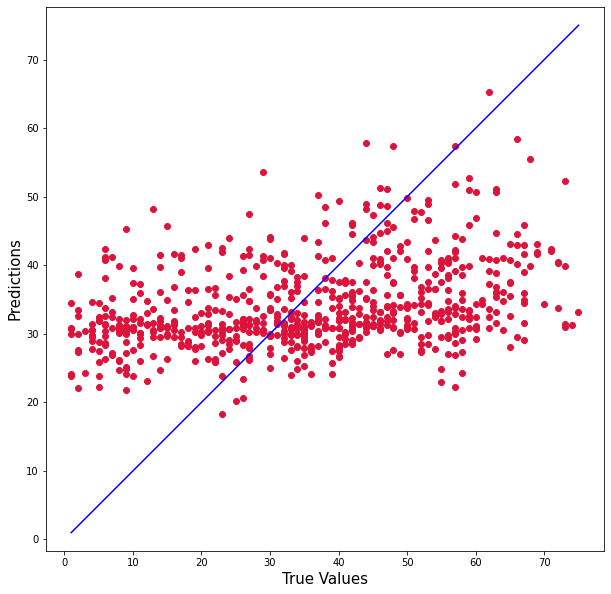

In [24]:
#Kode for plot hentet fra: https://stackoverflow.com/questions/58410187/how-to-plot-predicted-values-vs-the-true-value
#Tatt fra øverste kommentar fra Amit Amola
plt.figure(figsize=(10,10))
plt.scatter(y_test, svm.predict(X_test), c='crimson')

p1 = max(max(svm.predict(X_test)), max(y_test))
p2 = min(min(svm.predict(X_test)), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Plottet viser hvor modellen plaserrer de ulike verdiene, opp imot de faktiske verdiene. Den blå streken viser hvor punktene egentlig skal være. Vi ser her at nesten alle punktene blir plassert et sted mellom 20 og 50. Dette skyldes nok måten SVM fungerer på, den vil sette opp flere "streker" og vil gi punktene som er i et visst område en bestemt verdi. 

# Random forest model: 

In [25]:
RF = RandomForestRegressor()
start = time.time()
RF.fit(X_train, y_train)
stop = time.time()
RFtime = stop-start
print("Training set score: {:.4f}".format(RF.score(X_train, y_train)))
print("Test set score: {:.4f}".format(RF.score(X_test, y_test)))
print("Time: {:.3f}".format(RFtime))

Training set score: 0.8827
Test set score: 0.1674
Time: 4.358


In [26]:
RF2 = RandomForestRegressor()
start = time.time()
RF2.fit(X_train2, y_train2)
stop = time.time()
RFtime = stop-start
print("Training set 2 score: {:.4f}".format(RF2.score(X_train2, y_train2)))
print("Test set 2 score: {:.4f}".format(RF2.score(X_test2, y_test2)))
print("Time: {:.3f}".format(RFtime))

Training set 2 score: 0.8810
Test set 2 score: 0.1390
Time: 1.745


Her kan vi se at modellen fungerer litt bedre på det andre datasettet som inneholder færre verdier (Dette varierer noe per kjøring, noen ganger får den bedre score på det første settet). Vi kan også se at training set-scoren er betydelig høyere enn test set-scoren, noe som viser at modellen er veldig overfittet, noe som er ganske vanlig i decision tree og random forest modeller. Dette vil vi prøve å fikse under med teste ulike parametre med cross-validation. Modellen som kjører på det andre datasettet bruker betydelig mindre tid, noe som gir mening da det her er mye færre features.

In [27]:
print("MSE:", mean_squared_error(y_test2, RF2.predict(X_test2)))
print("RMSE:", math.sqrt(mean_squared_error(y_test2, RF2.predict(X_test2))))

MSE: 291.1448667664375
RMSE: 17.062967701031305


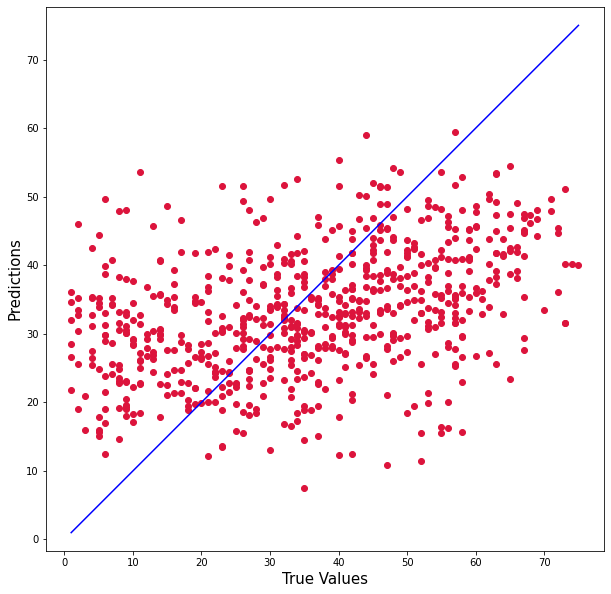

In [28]:
#Kode for plot hentet fra: https://stackoverflow.com/questions/58410187/how-to-plot-predicted-values-vs-the-true-value
#Tatt fra øverste kommentar fra Amit Amola
plt.figure(figsize=(10,10))
plt.scatter(y_test, RF2.predict(X_test2), c='crimson')

p1 = max(max(RF.predict(X_test)), max(y_test2))
p2 = min(min(RF.predict(X_test)), min(y_test2))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

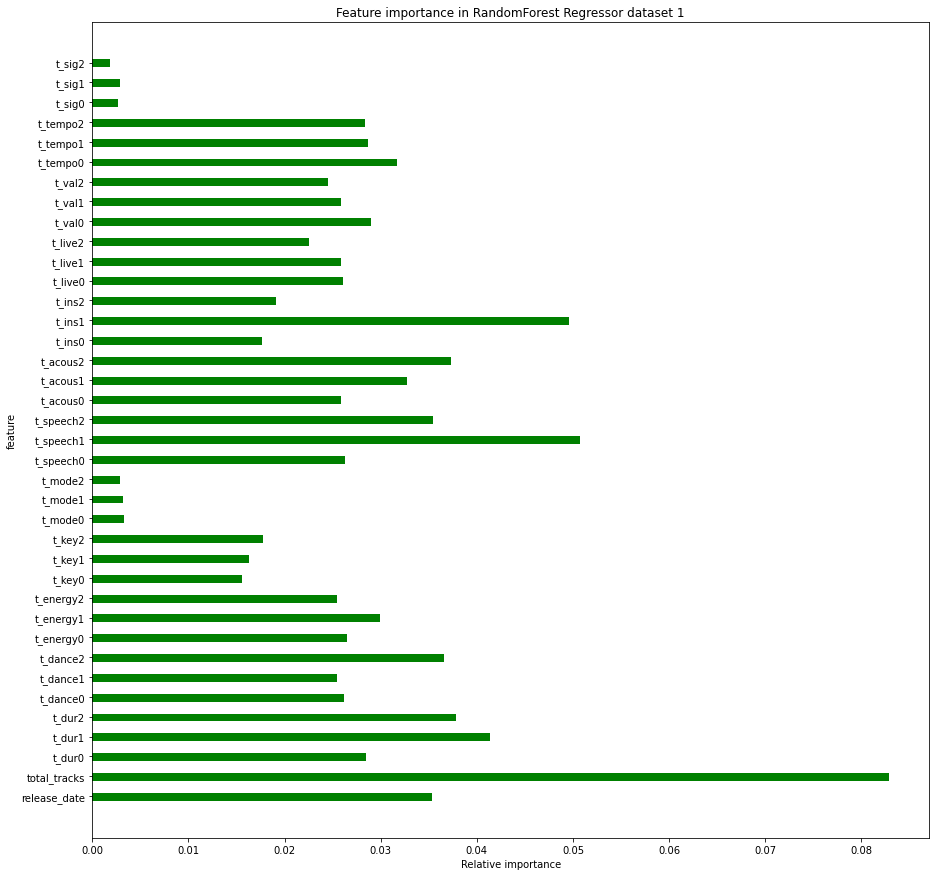

<Figure size 360x360 with 0 Axes>

In [29]:
#Plottet under er hentet fra: https://garg-mohit851.medium.com/random-forest-visualization-3f76cdf6456f
#Finner koden for det under punkt 1: Feature importance

col = albums.drop("popularity", axis=1).keys()

y = RF.feature_importances_

fig, ax = plt.subplots() 
width = 0.4 
ind = np.arange(len(y))
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature importance in RandomForest Regressor dataset 1')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(15, 15, forward=True)

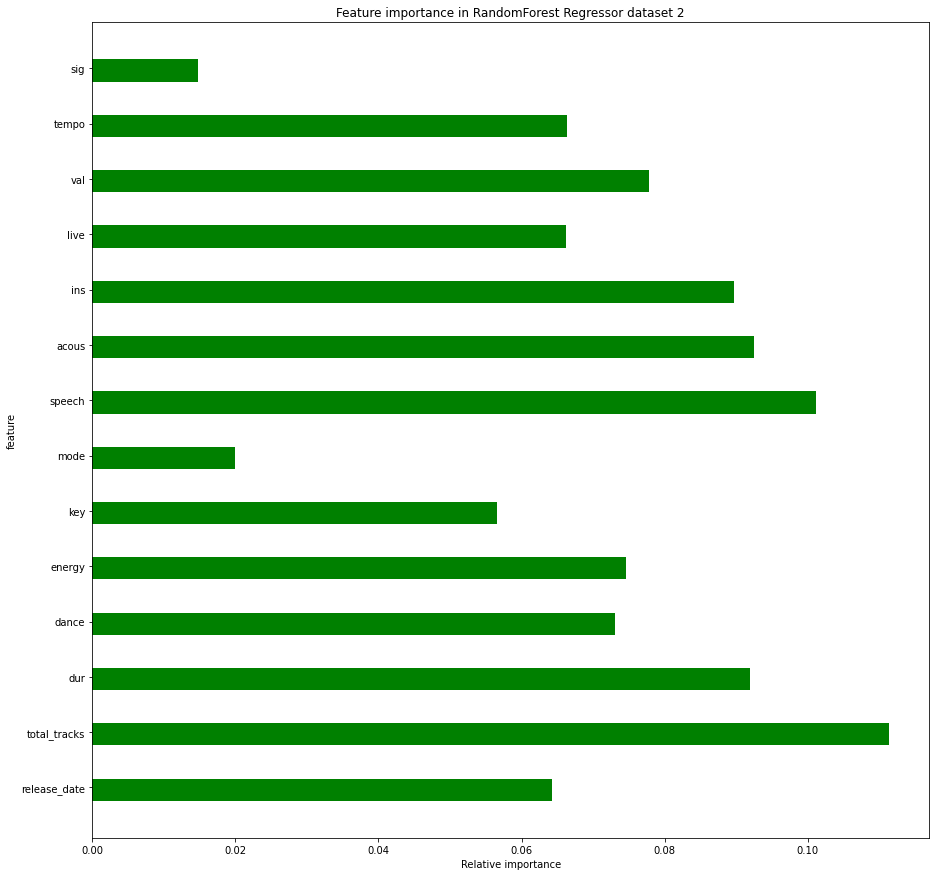

<Figure size 360x360 with 0 Axes>

In [30]:
col = albums2.drop("popularity", axis=1).keys()

y = RF2.feature_importances_

fig, ax = plt.subplots() 
width = 0.4 
ind = np.arange(len(y))
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature importance in RandomForest Regressor dataset 2')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(15, 15, forward=True)

Plottet over viser hvilke verdier modellen velger som viktige, altså hva modellen legger mest vekt på under regressionen.

In [31]:
#Kode for cross validation tatt fra "Introduction to machine learning with python" 
#Skrevet av Andreas C. Müller og Sarah Guido, s. 264 
trees = [10,50,100]
depths = [5,10,15]

best_score = 0
best_parameters = {}

for estimator in trees:
    for depth in depths:
        rfr = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
    
        rfr_pred = cross_val_predict(rfr, X_test, y_test, cv=KFold(n_splits=5, shuffle=True))
        
        scores = cross_val_score(rfr, X_test, y_test, cv=KFold(n_splits=5, shuffle=True))
        score = np.mean(scores)      
        if score > best_score:
            best_score = score
            best_parameters = {"estimator":estimator, "depth":depth}
            
rfr = RandomForestRegressor(n_estimators=best_parameters["estimator"], max_depth=best_parameters["depth"])

rfr.fit(X_train, y_train)
rfc_score = rfr.score(X_test, y_test)

print("Best score:\n", best_score, "\nBest parameters:\n", best_parameters)


Best score:
 0.16396148053187926 
Best parameters:
 {'estimator': 100, 'depth': 10}


In [32]:
RFNew = RandomForestRegressor(n_estimators=50, max_depth=5)
start = time.time()
RFNew.fit(X_train, y_train)
stop = time.time()
RFtime_new = stop-start
print("Training set score: {:.4f}".format(RFNew.score(X_train, y_train)))
print("Test set score: {:.4f}".format(RFNew.score(X_test, y_test)))
print("RMSE:", math.sqrt(mean_squared_error(y_test, RFNew.predict(X_test))))
print("Time: {:.3f}".format(RFtime_new))

Training set score: 0.2966
Test set score: 0.1361
RMSE: 17.090993872975343
Time: 0.801


Det varierer litt hva cross-valideringen gir som beste parametre, får n_estimators=50 og max_depth=5 noen ganger.
Ser at dette gir litt bedre test-score og mye værre trainingscore, som betyr at den ikke overfitter like mye som før.
Dette gjør også at modellen kjører mye raskere siden det er færre trær og alle trærne har maks dybde på 5.

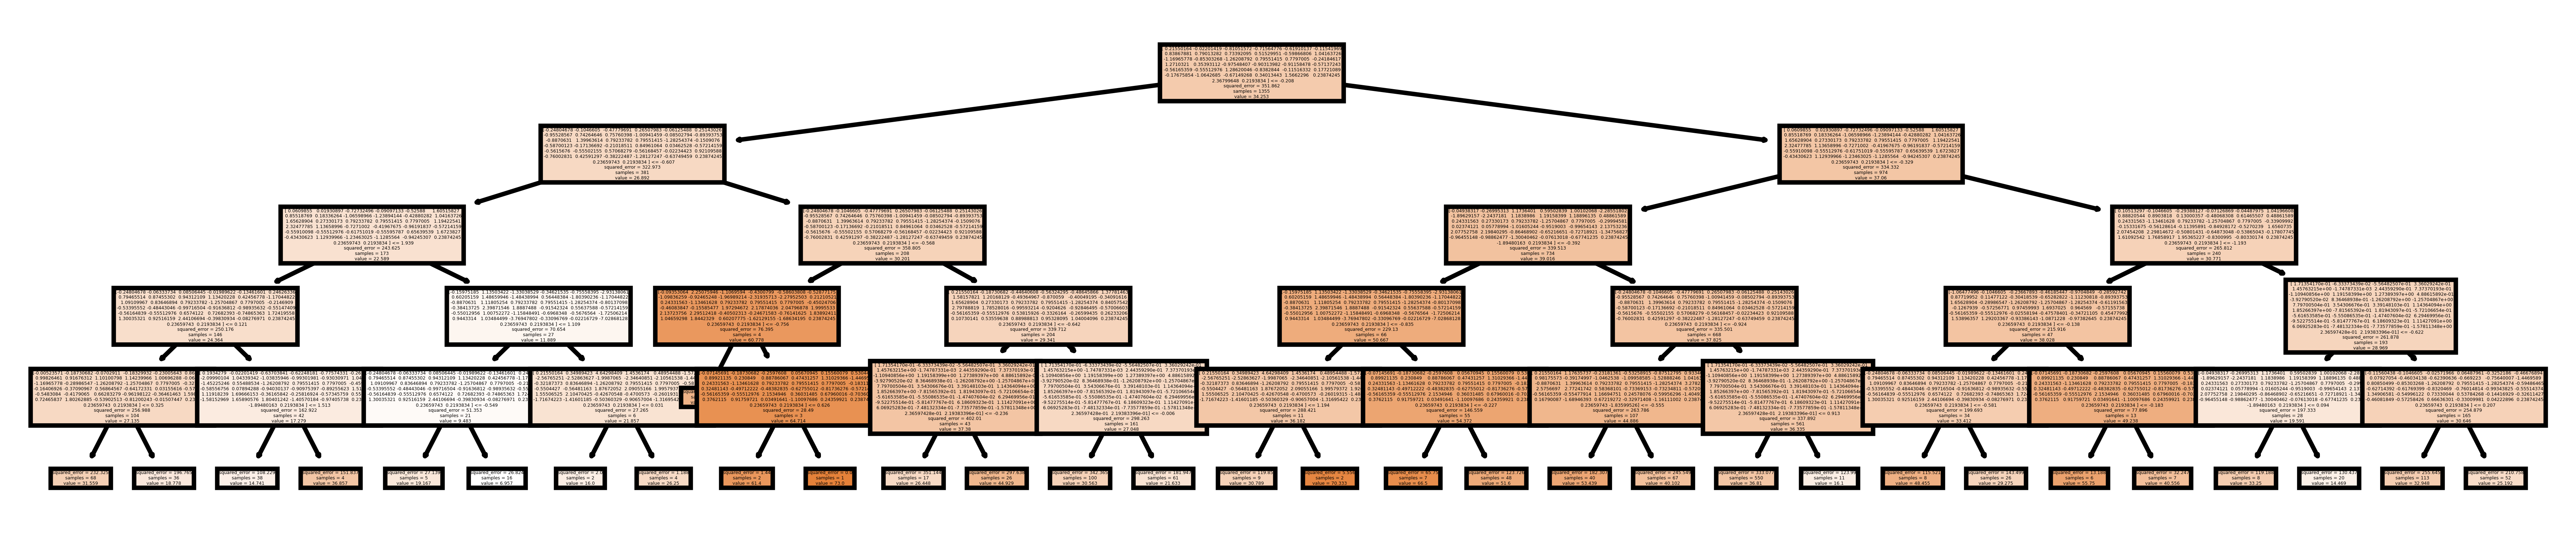

In [33]:
#Plot tatt fra: https://stackoverflow.com/questions/40155128/plot-trees-for-a-random-forest-in-python-with-scikit-learn
#Funnet i kommentar to av: Michael James Kali Galarnyk
fn=X_train
cn=y_train
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,2), dpi=900)
tree.plot_tree(RFNew.estimators_[0],
                   feature_names = fn, 
                   filled = True);

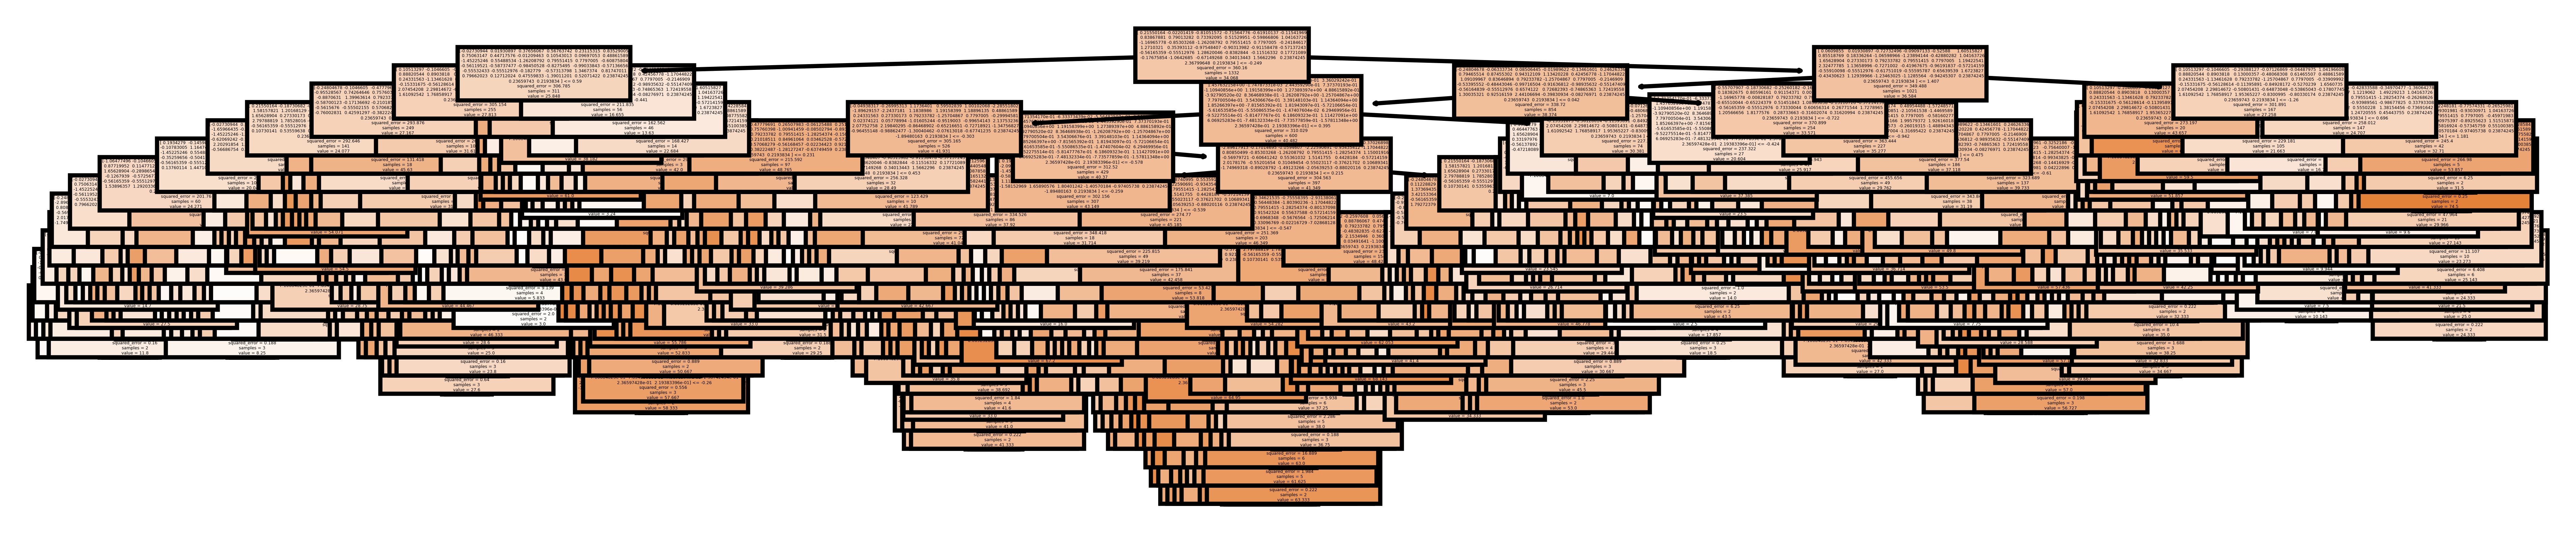

In [34]:
fn=X_train
cn=y_train
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,2), dpi=900)
tree.plot_tree(RF.estimators_[0],
                   feature_names = fn, 
                   filled = True);

De to plotttene over viser hvordan et av trærne blir på hver sin modell. Her kan vi tydelig se at standard-modellen til RF gir et veldig stort og uoversiktlige tre, som forteller hvorfor det blir så overfittet. Det første plottet derimot, som har trær på max_depth = 5 ser vi er mye mindre, vil derfor få en værre training set-score, men bli mindre overfittet, og vi ser det gir en noe bedre test set-score.

# Linear Regression

Dette problemet kan bli definert som et supervised regression problem fordi vi skal prøve å finne verdien på et float nummer fra et datasett med features som er numeriske.
Vi valgte først å se om det fantes noen korrelasjon mellom populæriteten av et album og de forskjellige featurene.

<AxesSubplot:>

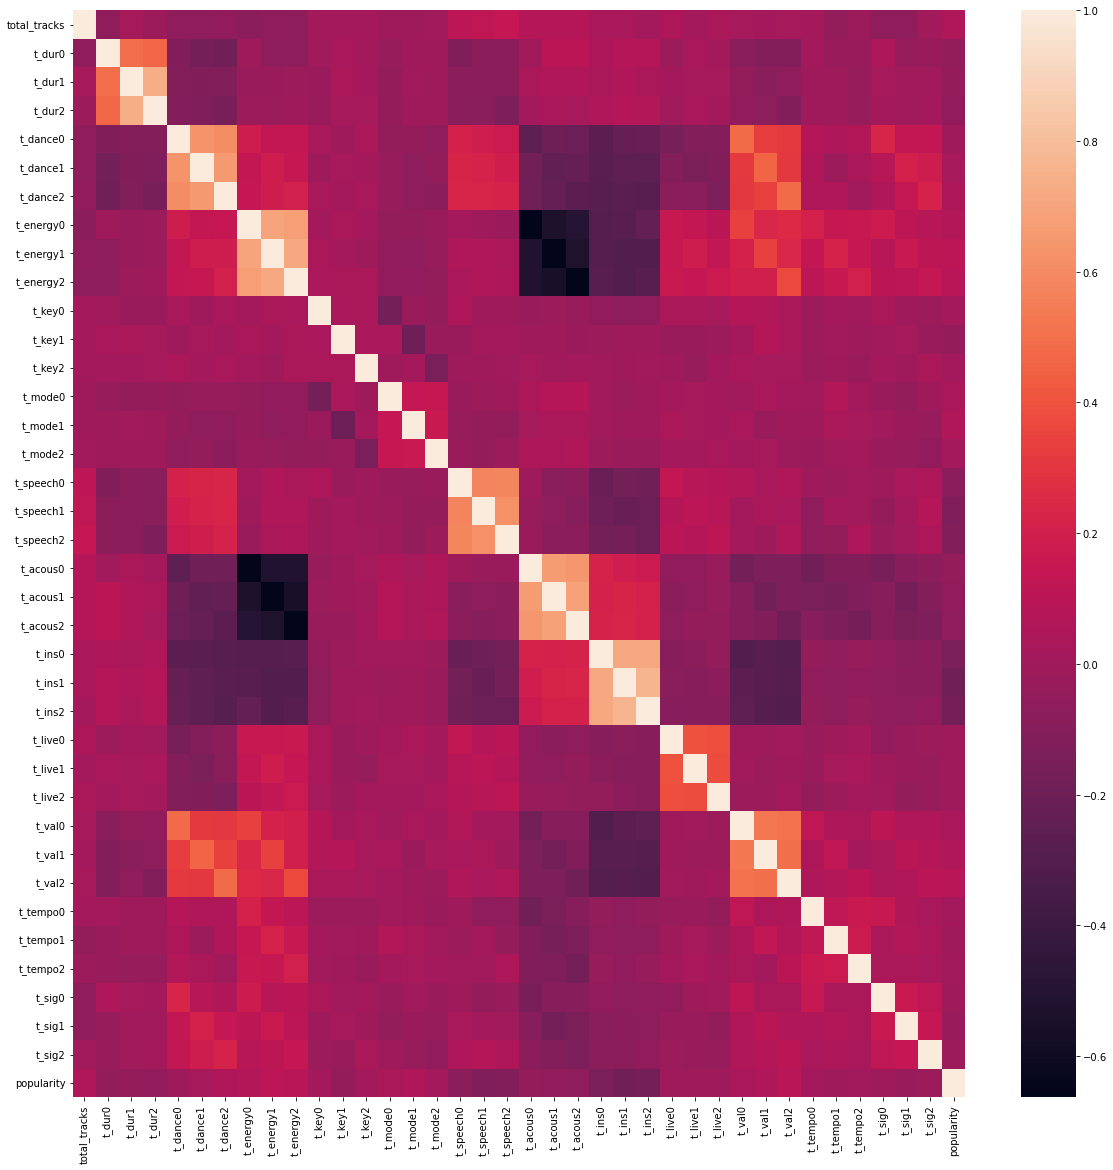

In [35]:
plt.subplots(figsize=(20,20))
sns.heatmap(albums.corr())

Datasett en viser svært liten korrelasjon mellom populæritet og de andre featurene

<AxesSubplot:>

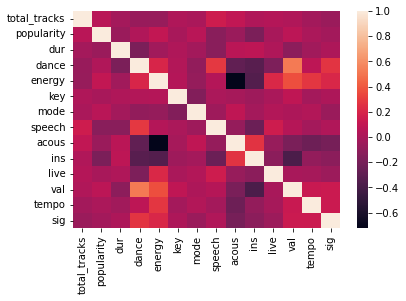

In [36]:
sns.heatmap(albums2.corr())

I datasett to ser vi også liten korrelasjon mellom populæritet og de andre featurene hvor de beste korrelasjonene er Val med 0.07338554523909686 og Energy med 0.09918229068206759. På grunn av at vi ikke finner noen god korrelasjon på på noen av datasettene er det forventet dårlige resultater fra modellene.

In [37]:
print('val: ', albums2['popularity'].corr(albums2['val']))
print('energy: ', albums2['popularity'].corr(albums2['energy']))

val:  0.07338554523909685
energy:  0.0991822906820676


Her kjøres en simpel linjær regressjons modell med de forskjellige featurene. Her ser vi at som forutsett vill scoren ikke bli veldig god men kanskje vi kan bruke flere metoder slik at vi kan få en bedre score. Vi bruker også begge datasettene vi har laget.

In [38]:
# Lager to LinearRegression klasser som heter lR og lR2
lR = LinearRegression()
lR2 = LinearRegression()


# Fitter datasettene
lR.fit(X_train, y_train)
lR2.fit(X_train2, y_train2)


# Lager prediction
lrPredict = lR.predict(X_test)
lrPredict2 =  lR2.predict(X_test2)


# Printer R2 score og MSE for det første datasettet
print('Datasett 1: R2 Score: ', r2_score(y_test, lrPredict))
print('Datasett 1: MSE: ', mean_squared_error(y_test, lrPredict))


# Printer R2 score og MSE for det andre datasettet
print('Datasett 2: R2 Score: ', r2_score(y_test2, lrPredict2))
print('Datasett 2: MSE: ', mean_squared_error(y_test2, lrPredict2))

Datasett 1: R2 Score:  0.0833876326963795
Datasett 1: MSE:  309.9399613630151
Datasett 2: R2 Score:  0.10294006549821344
Datasett 2: MSE:  303.32857307793205


Her blir det laget og kjørt en pipeline for hver av datasettene som bruker linjær reggresjon med Lasso med alpha satt til 0.1

In [39]:
# Lager to pipelines som skal bruke Lasso med alpha 0.1
lassoPipe = make_pipeline(linear_model.Lasso(alpha = 0.1))
lassoPipe2 = make_pipeline(linear_model.Lasso(alpha = 0.1))

# Trener dataen med pipelinenene
lassoPipe.fit(X_train, y_train)
lassoPredict = lassoPipe.predict(X_test)


lassoPipe2.fit(X_train2, y_train2)
lassoPredict2 = lassoPipe2.predict(X_test2)


# Printer R2 score og MSE for det første datasettet
print('Datasett 1: R2 Score: ', r2_score(y_test, lassoPredict))
print('Datasett 1: MSE: ', mean_squared_error(y_test, lassoPredict))


# Printer R2 score og MSE for det andre datasettet
print('Datasett 2: R2 Score: ', r2_score(y_test2, lassoPredict2))
print('Datasett 2: MSE: ', mean_squared_error(y_test2, lassoPredict2))

Datasett 1: R2 Score:  0.08745551944754482
Datasett 1: MSE:  308.5644609798006
Datasett 2: R2 Score:  0.10238316001006476
Datasett 2: MSE:  303.51688306766897


In [40]:
# Lager to pipelines med Lasso
gsLassoPipe = Pipeline(steps=[
     ('lasso', linear_model.Lasso())
])

gsLassoPipe2 = Pipeline(steps=[
     ('lasso', linear_model.Lasso())
])



# Definerer parameterene gridsearch skal bruke
gsLassoGrid = {'lasso__alpha': np.arange(0.01, 1, 0.01)}
gsLassoGrid2 = {'lasso__alpha': np.arange(0.01, 1, 0.01)}


# Gjennomfører gridsearch på begge datasettene for å finne den beste alpha verdien for vær av dem.
lassoGs = GridSearchCV(gsLassoPipe, gsLassoGrid, cv=5)
lassoGs.fit(X_train, y_train)
lassoGsPred = lassoGs.predict(X_test)

lassoGs2 = GridSearchCV(gsLassoPipe2, gsLassoGrid2, cv=5)
lassoGs2.fit(X_train2, y_train2)
lassoGsPred2 = lassoGs2.predict(X_test2)


# Printer resultatet for det første datasettet.
values = [float(x) for x in list(lassoGs.best_params_.values())]
print('Det beste alpha parameteret for det første datasettet: ', values[0])

# Printer resultatet for det andre datasettet.
values2 = [float(x) for x in list(lassoGs2.best_params_.values())]
print('Det beste alpha parameteret for det andre datasettet: ', values2[0])

Det beste alpha parameteret for det første datasettet:  0.74
Det beste alpha parameteret for det andre datasettet:  0.74


Her lager jeg den samme modellen uten pipeline slik at man kan lage en plot ut av de forskjellige alpha verdiene og koeffisientene. Her brukes det andre datasettet for visualisering.

Text(0.5, 1.0, 'Lasso coefficients for forskjellige alpha inputs')

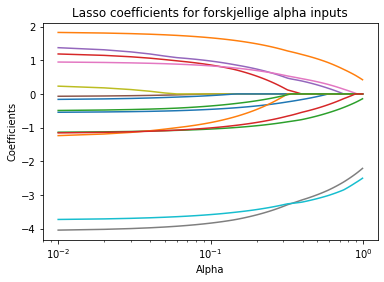

In [41]:
# Plott tatt fra punkt 1.4 i denne artikkeleen: https://www.kirenz.com/post/2019-08-12-python-lasso-regression-auto/
# Definerer de samme parameterene som brukes til gridsearch
alphas = np.arange(0.01, 1, 0.01)


# Gjennomfører Linjær regresjon med Lasso slik at de forskjellige koeffisientene kan bli lagret i listen coefs slik at man kan lage en plot
lassoplt = linear_model.Lasso()
coefs = []
for a in alphas:
    lassoplt.set_params(alpha=a)
    lassoplt.fit(X_train2, y_train2)
    coefs.append(lassoplt.coef_)


# Lager et plot med alphas(Parameterene til gridsearch) og koeffisientene til disse
coefplot = plt.gca()
coefplot.plot(alphas, coefs)
coefplot.set_xscale('log')
plt.axis('tight')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso coefficients for forskjellige alpha inputs')


Her lages en siste pipeline med Linjær regressjon med Lasso med den optimale alpha verdien.

In [42]:
# Lager to optimale Lasso pipelines med den beste alpha verdien for hver av datasettene
optimalLasso = Pipeline(steps=[
     ('lasso', linear_model.Lasso(alpha=values[0]))
])

optimalLasso2 = Pipeline(steps=[
     ('lasso', linear_model.Lasso(alpha=values2[0]))
])

# Trener dataen med pipelinen for det første datasettet.
optimalLasso.fit(X_train, y_train)
optimalLassoPred = optimalLasso.predict(X_test)


# Trener dataen med pipelinen for det andre datasettet.
optimalLasso2.fit(X_train2, y_train2)
optimalLassoPred2 = optimalLasso2.predict(X_test2)


# Printer R2 score, MSE, og RMSE for det første datasettet.
print('R2 Score: ', r2_score(y_test, optimalLassoPred))
print('Mean squared error: ', mean_squared_error(y_test, optimalLassoPred))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, optimalLassoPred)))


# Printer R2 score, MSE, og RMSE for det andre datasettet.
print('R2 Score: ', r2_score(y_test2, optimalLassoPred2))
print('Mean squared error: ', mean_squared_error(y_test2, optimalLassoPred2))
print('RMSE: ', math.sqrt(mean_squared_error(y_test2, optimalLassoPred2)))

R2 Score:  0.07606712695785922
Mean squared error:  312.41529046252214
RMSE:  17.67527341973872
R2 Score:  0.07892412455391284
Mean squared error:  311.4492357199487
RMSE:  17.647924402601816


Her ser vi at vi får dårlige resultater fra begge datasettene når vi kjøre linjær regressjon med en optimal Lasso. Dette er forventet da vi fant ut tidligere at det fantes liten korrelasjon mellom populæriteten og de andre featurene i begge datasettene.

# KNN model:

Nedenfor bruker vi knn.fit for å trene KNN regresjonsmodellen på treningssettene vi lagde tidligere.
Vi har satt antall neighbors til 20, noe som tilsynelatende ofte ga ett litt bedre resultat enn andre n_neighbors verdier, vi kommer tilbake til dette under cross validation og ploten vi har laget

In [43]:
# Training the data on the KNN regressor. 

knn = KNeighborsRegressor(n_neighbors=20)
knn.fit(X_train, y_train)
knn2 = KNeighborsRegressor(n_neighbors=20)
knn2.fit(X_train2, y_train2)
print("training set score: ", knn.score(X_train, y_train))
print("test set score: ", knn.score(X_test, y_test))
print("training set2 score: ", knn2.score(X_train2, y_train2))
print("test set2 score: ", knn2.score(X_test2, y_test2))

training set score:  0.14974084615216454
test set score:  0.0992043321750864
training set2 score:  0.15455024224890446
test set2 score:  0.11900184962269289


ovenfor kan vi se relativt store verdiforskjeller på de to forskjellige datasettene vi har laget.
Treningssettet har høyest score noe som også er forutsett siden det er på det settet vi trener modellen før vi tester den på test settet.
"test set" beholder de fleste kolonnene utenom de som inneholder en string
"test set2" bruker et dataset der t_ kolonnene er slått sammen og kun gjennomsnittet blir brukt.
Dette blir forklart under preprocessingen men det er gjennomgående i alle modellene.
i KNN modellen er det "test set2" som får høyest score, noe som ikke er overraskende ettersom KNN ofte liker få features.

In [44]:
# En variasjon av cross validation som har blitt brukt tidligere, men er tilpasset KNN regresjon.
# grid search on RFC with cross validation
neighbors = [10, 20, 40, 60, 80, 100]
weigths = ['uniform', 'distance']

best_score = 0
best_parameters = {}

for i in neighbors:
    for j in weigths:
        knn = KNeighborsRegressor(n_neighbors=i, weights=j)

        knn_pred = cross_val_predict(knn, X_test, y_test, cv=KFold(n_splits=5, shuffle=True))


        scores = cross_val_score(knn, X_test, y_test, cv=KFold(n_splits=5, shuffle=True))

        score = np.mean(scores)
        if score > best_score:
            best_score = score
            best_parameters = {"neighbors":i, "weights":j}

knn = KNeighborsRegressor(n_neighbors=best_parameters["neighbors"], weights=best_parameters["weights"])

knn.fit(X_train, y_train)
knn_score = knn.score(X_test, y_test)

print("Best score:\n", best_score, "\nBest parameters:\n", best_parameters)

Best score:
 0.0958758048726936 
Best parameters:
 {'neighbors': 40, 'weights': 'uniform'}


Cross validation koden prøver å finne hvor mange neighbors som er optimalt. i Cross validation koden har vi lagt inn neighbors = [10, 20, 40, 60, 80, 100] noe som gjør at den aldri er helt nøyaktig på hvor mange neighbors som er optimalt. Vi får også dårligere resultat enn om vi bruker "knn.score". Dette forteller oss at denne formen for cross-validation ikke er optimal for KNN.

MSE og RMSE verdiene korresponderer til den gjennomsnittlige differansen mellom det observerte utfallet og det utfallet som ble gjettet. Jo lavere RMSE, desto bedre er modellen. Her er RMSE'en ganske lik som den har vært på de andre modelllene.

In [45]:
knn.fit(X_train ,y_train)
pred_y = knn.predict(X_test)

mse = mean_squared_error(y_test, pred_y)
print("Mean Squared Error:", mse)

rmse = math.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 298.7508899359886
Root Mean Squared Error: 17.28441176135273


Denne ploten viser hvor MSE'en er lavest i henhold til k-verdien, eller antall neighbors. Det betyr at der K-verdien er lavest er den mest optimale mengden neighbors.


299.9495984312571


Text(0.5, 1.0, 'ELBOW PLOT')

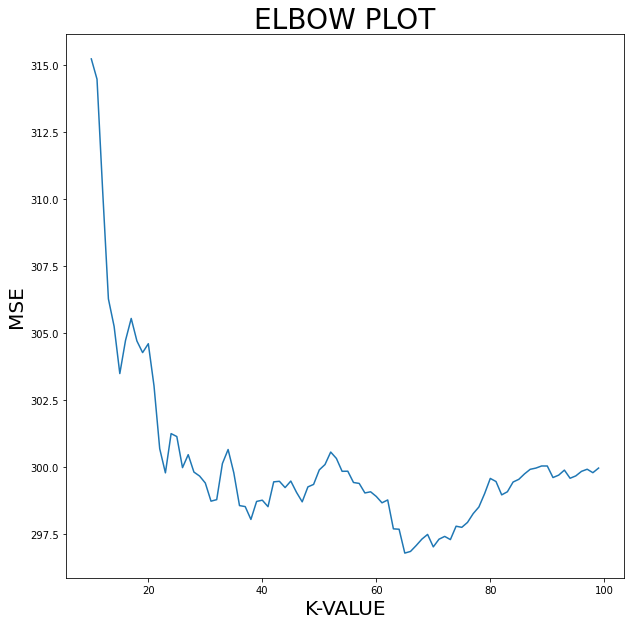

In [46]:
# https://aamir07.medium.com/knn-regression-with-python-c11cbc5aa9a8
#Deler av koden nedenfor er hentet fra linken øverst i denne cellen. Variabelnavn har blitt endret for å samsvare med tidligere variabler og
#elbow ploten har blitt modifisert for å visualisere dataene våre bedre.

fig,ax=plt.subplots(figsize=(10,10))
k_list=np.arange(10,100,1)
knn_dict={} # bruker en dictionary til å paire k og mse
for i in k_list:
#Knn Model Creation
    knn=KNeighborsRegressor(n_neighbors=int(i))
    model_knn=knn.fit(X_train,y_train)
    pred_y=model_knn.predict(X_test)
#Lagre mean squared error  
    mse=mean_squared_error(y_test, pred_y)
    knn_dict[i]=mse
print(mse)
#Plotte resultatene
ax.plot(knn_dict.keys(),knn_dict.values())
ax.set_xlabel('K-VALUE', fontsize=20)
ax.set_ylabel('MSE' ,fontsize=20)
ax.set_title('ELBOW PLOT' ,fontsize=28)

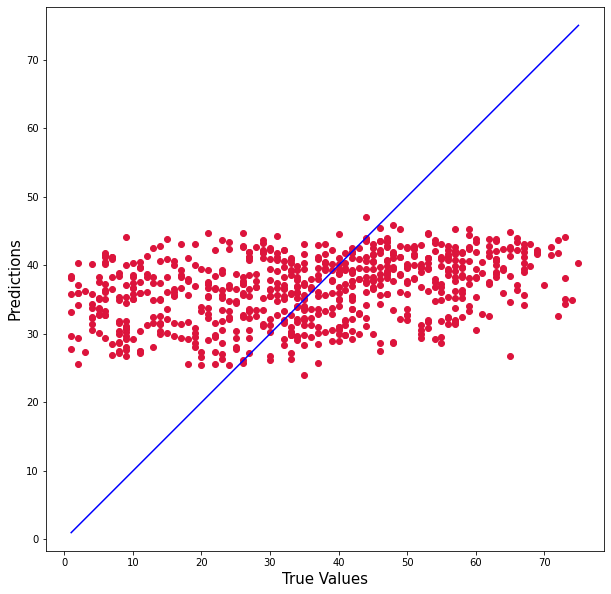

In [47]:
#Kode for plot hentet fra: https://stackoverflow.com/questions/58410187/how-to-plot-predicted-values-vs-the-true-value
#Tatt fra øverste kommentar fra Amit Amola
# Dette plotet har blitt brukt tidligere men er re-fitet til å passe til knn
plt.figure(figsize=(10,10))
plt.scatter(y_test, knn.predict(X_test), c='crimson')

p1 = max(max(knn.predict(X_test)), max(y_test))
p2 = min(min(knn.predict(X_test)), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Den siste plotten vi har lagt til i KNN-delen er et scatterplot vi har brukt tidligere. Hvis vi sammenligner dette plottet med det vi kan se under SVM-seksjonen kan vi se at popularity predictionsene er mye tettere rundt 30 og 40.

#Resultater

In [48]:
print("Resultater for de ulike modellene for dataset 1:")
print()
print("SVM: ")
print("Test set score: {:.4f}".format(svm.score(X_test, y_test)))
print("RMSE:", math.sqrt(mean_squared_error(y_test, svm.predict(X_test))))
print()
print("Random Forest: ")
print("Test set score: {:.4f}".format(RF.score(X_test, y_test)))
print("RMSE:", math.sqrt(mean_squared_error(y_test, RF.predict(X_test))))
print()
print("Linear regression: ")
print("Test set score: {:.4f}".format(optimalLasso.score(X_test, y_test)))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, optimalLasso.predict(X_test))))
print()
print("KNN: ")
print("Test set score: {:.4f}".format(knn.score(X_test, y_test)))
print("RMSE:", math.sqrt(mean_squared_error(y_test, knn.predict(X_test))))

Resultater for de ulike modellene for dataset 1:

SVM: 
Test set score: 0.1212
RMSE: 17.23792921652201

Random Forest: 
Test set score: 0.1674
RMSE: 16.778932497059294
Linear regression: 
Test set score: 0.0761
RMSE:  17.67527341973872

KNN: 
Test set score: 0.1129
RMSE: 17.319053046609017


In [49]:
print("Resultater for de ulike modellene for dataset 2:")
print()
print("SVM: ")
print("Test set score: {:.4f}".format(svm2.score(X_test2, y_test2)))
print("RMSE:", math.sqrt(mean_squared_error(y_test2, svm2.predict(X_test2))))
print()
print("Random Forest: ")
print("Test set score: {:.4f}".format(RF2.score(X_test2, y_test2)))
print("RMSE:", math.sqrt(mean_squared_error(y_test2, RF2.predict(X_test2))))
print()
print("Linear regression")
print("Test set score: {:.4f}".format(optimalLasso2.score(X_test2, y_test2)))
print("RMSE: ", math.sqrt(mean_squared_error(y_test2, optimalLasso2.predict(X_test2))))
print()
print("KNN: ")
print("Test set score: {:.4f}".format(knn2.score(X_test2, y_test2)))
print("RMSE:", math.sqrt(mean_squared_error(y_test2, knn2.predict(X_test2))))

Resultater for de ulike modellene for dataset 2:

SVM: 
Test set score: 0.1483
RMSE: 16.970101353426358

Random Forest: 
Test set score: 0.1390
RMSE: 17.062967701031305

Linear regression
Test set score: 0.0789
RMSE:  17.647924402601816

KNN: 
Test set score: 0.1190
RMSE: 17.25970741351081


# CNN

In [50]:
df = pd.read_csv('albums_all.csv')
covers = './images/'

Laster inn albums_all datasettet på nytt da vi ikke bruker preprocessingen vi har brukt tidligere. Laster inn sti til mappen med albumcoverene. Bytt på stien om dette ligger i en annen sti. Treningen av CNNen er sterkt basert på Vijayabhaskar J's "Tutorial on Keras flow_from_dataframe": https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c



In [51]:
newdf = df
for i in range(8, 43, 3):
  col = df.columns[i]
  col2 = df.columns[i+1]
  col3 = df.columns[i+2]
  colname = col[2:-1]
  newdf[colname] = (df[df.columns[i]] + df[df.columns[i+1]] + df[df.columns[i+2]]) / 3

In [52]:
newdf = newdf[['id', 'dance', 'energy', 'acous', 'popularity']]


Featuresene vi har valgt å predicte er dance, energy, acous og popularity. Vi tror dette er egenskaper som skal være mulig å gjøre en god prediksjon på basert på albumcoveret. For de 3 første verdiene har vi valgt å kjøre det samme python-scriptet vi gjorde i preprocessingen for album2 datasettet, altså finne gjennomsnittsscoren for de 3 første sangene i albumet for disse egenskapene, da vi tror dette vil gi et bedre bilde av hele albumet, og igjen være lettere å gjette basert på albumcoveret.

In [53]:
def append_ext(fn):
    return str(fn)+".png"

newdf["id"]=newdf["id"].apply(append_ext)

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

/var/folders/lt/nnz1953n6x76fn470sp7m8x00000gn/T/ipykernel_5005/2076077557.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Legger til ".png" på slutten av alle id'ene, for å matche de opp med filnavnene til albumcoverene.

In [54]:
newdf.head()

id     dance    energy     acous  popularity
0   22352.png  0.563667  0.426000  0.503133          21
1  106534.png  0.663000  0.878667  0.043793          14
2   23608.png  0.283667  0.976000  0.090466          41
3    8655.png  0.886333  0.713667  0.189233           1
4   49670.png  0.766333  0.828333  0.099600          47

In [55]:
import numpy as np
newdf['dance'] = np.asarray(newdf['dance']).astype('float32')
newdf['energy'] = np.asarray(newdf['energy']).astype('float32')
newdf['acous'] = np.asarray(newdf['acous']).astype('float32')
newdf['popularity'] = np.asarray(newdf['popularity']).astype('int64')



/var/folders/lt/nnz1953n6x76fn470sp7m8x00000gn/T/ipykernel_5005/4068231855.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lt/nnz1953n6x76fn470sp7m8x00000gn/T/ipykernel_5005/4068231855.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lt/nnz1953n6x76fn470sp7m8x00000gn/T/ipykernel_5005/4068231855.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Modellen vil ha numpy-arrays, så gjør alle radene om til dette.

In [56]:
testsplit = round(len(newdf) * 0.2)

Finner 0.2 av dataen, for å splitte opp datasettet i test og train dataset.

In [57]:
traindata = newdf.iloc[testsplit:]
testdata = newdf.iloc[:testsplit]


In [58]:
testdata.head()

id     dance    energy     acous  popularity
0   22352.png  0.563667  0.426000  0.503133          21
1  106534.png  0.663000  0.878667  0.043793          14
2   23608.png  0.283667  0.976000  0.090466          41
3    8655.png  0.886333  0.713667  0.189233           1
4   49670.png  0.766333  0.828333  0.099600          47

In [59]:
train_generator=datagen.flow_from_dataframe(
            dataframe=traindata,
            directory=covers,
            x_col="id",
            y_col=['dance', 'energy', 'acous','popularity'],
            subset="training",
            batch_size=32,
            seed=42,
            shuffle=True,
            class_mode="raw",
            target_size=(160,160)
            )

valid_generator=datagen.flow_from_dataframe(
            dataframe=traindata,
            directory=covers,
            x_col="id",
            y_col=['dance', 'energy', 'acous', 'popularity'],
            subset="validation",
            batch_size=32,
            seed=42,
            shuffle=True,
            class_mode="raw",
            target_size=(160,160))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
            dataframe=testdata,
            directory=covers,
            x_col="id",
            y_col=None,
            batch_size=27,
            seed=42,
            shuffle=False,
            class_mode=None,
            target_size=(160,160))

Found 1700 validated image filenames.
Found 566 validated image filenames.
Found 567 validated image filenames.


Her bruker vi funksjonen flow_from_dataframefe. Her gir vi datasettet og directoriet til bildene som input, og spesifiserer hva vi ønsker å gjette i y_col parameteret. Returnert får vi en generator som kan brukes til å trene Keras CNN modeller som vi ser litt ned i koden. Bruker batch_size = 27 på test_generator siden det er delelig med 567 (Størrelsen på testsettet).

In [60]:
model = Sequential()
model.add(Conv2D(32, (3, 3),
                 input_shape=(160,160,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3),))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

2022-05-12 13:52:45.972448: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Bygger modellene, bruker "mse" (Mean squared error) som loss funksjon som er egnet til regressionsproblemer som vi har. Øverst i koden spesifiserer vi input_shape som er størrelsen på bildene vi sender inn, så bygger vi forskjellige lag i modellen, i linjen før compile velger vi hvor mange outputs modellen skal gi, derfor har vi 4 her, siden modellen skal gjette 4 features.

In [61]:
class mycallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('loss') <= 0.05:       
            self.model.stop_training = True
        if logs.get('acc') == 1.00:
            self.model.stop_training = True

Lager en callback-klasse for å stoppe modellen i å trene om den når perfekt score.

In [73]:
callbacks = [mycallback()]
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks = callbacks,
                    epochs=5
)

Epoch 1/5
14/53 [======>.......................] - ETA: 1:44 - loss: 88.5530 - mse: 88.5530 - mae: 4.8454

KeyboardInterrupt: 

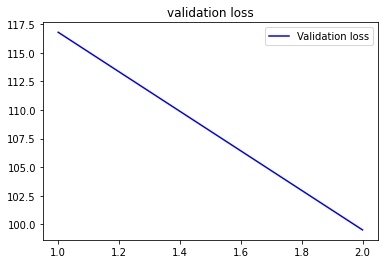

In [63]:
val_loss = history.history['val_loss']
epochs = range(1, len(val_loss) + 1)
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('validation loss')
plt.legend()
plt.show()

Plot som viser hvordan loss (Mean squared error) blir mindre over flere epochs.

In [64]:
model.evaluate_generator(generator=valid_generator,steps=STEP_SIZE_VALID)

/var/folders/lt/nnz1953n6x76fn470sp7m8x00000gn/T/ipykernel_5005/1446538322.py:1: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



[100.87030029296875, 100.87030029296875, 4.363708972930908]

Vi kan se at vi får en veldig høy loss-score, som tyder på at modellen ikke er veldig god, og sliter med å gjette riktig. En grunn til at loss scoren blir så høy er at den skal gjette 3 features mellom 0 og 1, og en feature mellom 1 og 100. Hadde vi kun hatt 3 features mellom 0 og 1 som skulle gjettes, ville denne loss scoren blitt mye mindre, da det ikke vill vært mulig å ha over 1 i feil.

In [65]:
test_generator.reset()
pred=model.predict(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

21/21 [==============================] - 19s 885ms/step


In [66]:
print(pred)

[[ 0.6334526   0.57080513  0.4346688  33.170906  ]
 [ 0.6282427   0.34157982  0.54451144 31.414742  ]
 [ 0.6867885   0.47182393  0.4790389  33.45904   ]
 ...
 [ 0.6803087   0.5079769   0.44743773 33.915752  ]
 [ 0.5985015   0.5726436   0.4541004  32.324078  ]
 [ 0.7419131   0.48353785  0.45921305 34.252636  ]]


Printer ut prediksjonene for å se om vi får riktige verdier. De 3 første verdiene skal være mellom 0 og 1 og den siste mellom 1 og 100. Så det ser riktig ut.

In [67]:
dancepred = []
energypred = []
acouspred = []
popularitypred = []

for i in pred:
  dancepred.append(i[0])
  energypred.append(i[1])
  acouspred.append(i[2])
  popularitypred.append(i[3])

Legger gitte predictions for de ulike egenskapene i hver sin liste, for å gjøre det lettere å evaluere senere. Vi vet rekkefølgen dance, energy, acous og popularity ligger i, så vi kan gjøre dette.

In [68]:
dance_score = r2_score(testdata.dance, dancepred)
acous_score = r2_score(testdata.acous, acouspred)
energy_score = r2_score(testdata.energy, energypred)
popularity_score = r2_score(testdata.popularity, popularitypred)

print("Scores:")
print()
print("dance_score:")
print("R2:", dance_score)
print("MSE:", mean_squared_error(testdata.dance, dancepred))
print("RMSE:", math.sqrt(mean_squared_error(testdata.dance, dancepred)))
print()
print("acous_score:")
print("R2:", acous_score)
print("MSE:", mean_squared_error(testdata.acous, acouspred))
print("RMSE:", math.sqrt(mean_squared_error(testdata.acous, acouspred)))
print()
print("energy_score:")
print("R2:", energy_score)
print("MSE:", mean_squared_error(testdata.energy, energypred))
print("RMSE:", math.sqrt(mean_squared_error(testdata.energy, energypred)))
print()
print("popularity:")
print("R2:", popularity_score)
print("MSE:", mean_squared_error(testdata.popularity, popularitypred))
print("RMSE:", math.sqrt(mean_squared_error(testdata.popularity, popularitypred)))

Scores:

dance_score:
R2: -0.28227962405207263
MSE: 0.033006698
RMSE: 0.1816774556546373

acous_score:
R2: -0.21702989509363402
MSE: 0.1053917
RMSE: 0.32464088397188545

energy_score:
R2: -0.32658127731223296
MSE: 0.07146554
RMSE: 0.2673303891292921

popularity:
R2: -0.04640279063386643
MSE: 380.76008274755765
RMSE: 19.513074661558534


Vi ser her at alle prediksjonene får negativ r2 score (Kan variere noe per kjøring) en r2 score på 0 betyr at modellen er like god som en modell som bruker gjennomsnittet på dataen for hvert punkt, så en negativ score sier oss at vår modell er enda værre enn dette igjen. Det finnes flere grunner til at vi får så dårlige scores; for det første er datasettet vårt ganske lite på kun 2833 album, ville nok fått en bedre score med et betydelig større datasett. Det ville nok også vært mulig å gjort noen endringer til modellen for å gjøre den mer egnet til denne oppgaven, da vi kun har brukt en pre-trained modell for å gjøre dette. Vi tror også at det er en vanskelig jobb å gjette popularitet og våre andre features kun basert på et album cover. Under har vi lagt til plot for hvordan de predikerte verdiene ser ut i forhold til de faktiske verdiene.

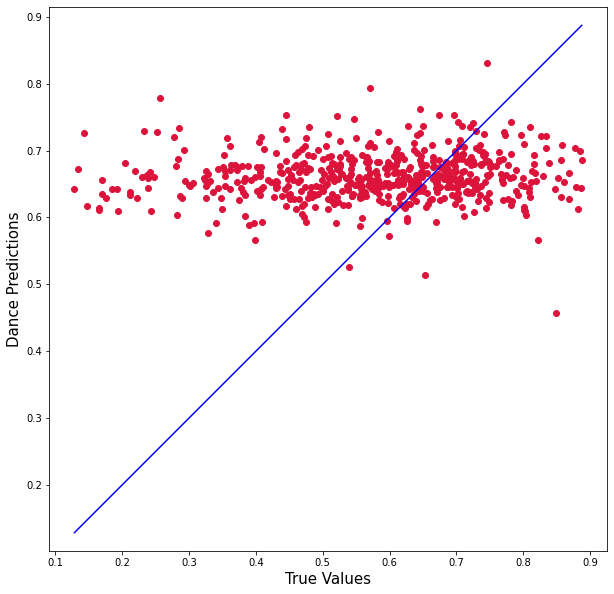

In [69]:
plt.figure(figsize=(10,10))
plt.scatter(testdata.dance, dancepred, c='crimson')

p1 = max(max(dancepred), max(testdata.dance))
p2 = min(min(dancepred), min(testdata.dance))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Dance Predictions', fontsize=15)
plt.axis('equal')
plt.show()

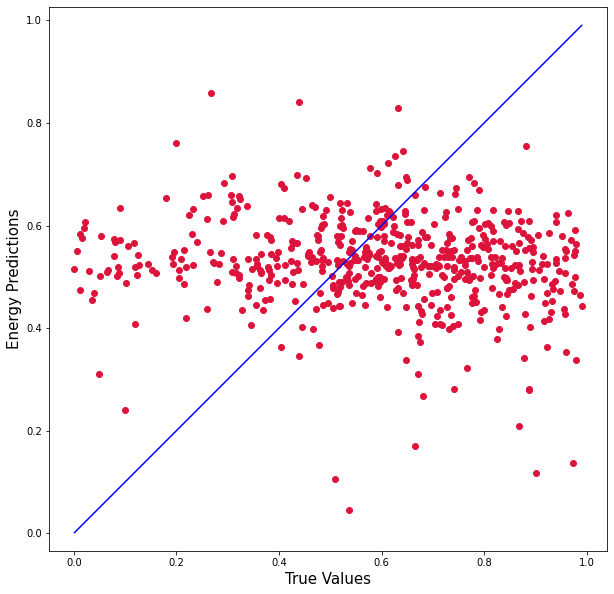

In [70]:
plt.figure(figsize=(10,10))
plt.scatter(testdata.energy, energypred, c='crimson')

p1 = max(max(energypred), max(testdata.energy))
p2 = min(min(energypred), min(testdata.energy))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Energy Predictions', fontsize=15)
plt.axis('equal')
plt.show()

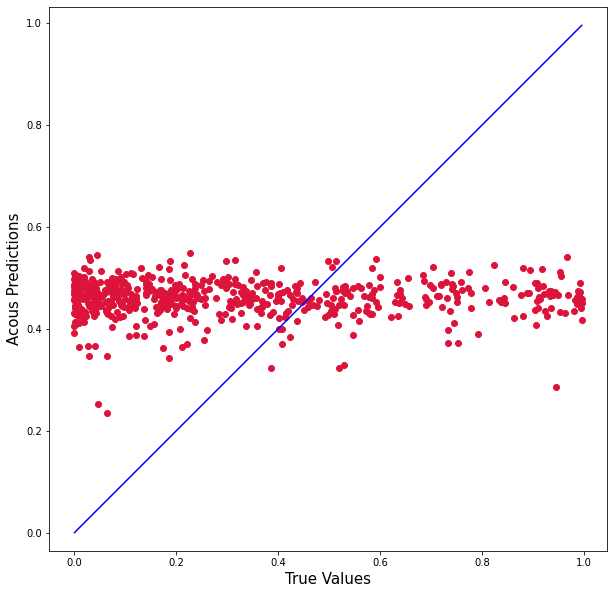

In [71]:
plt.figure(figsize=(10,10))
plt.scatter(testdata.acous, acouspred, c='crimson')

p1 = max(max(acouspred), max(testdata.acous))
p2 = min(min(acouspred), min(testdata.acous))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Acous Predictions', fontsize=15)
plt.axis('equal')
plt.show()

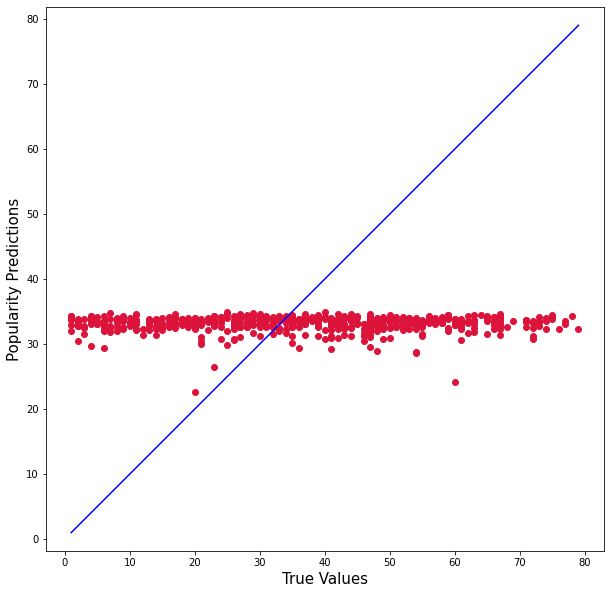

In [72]:
plt.figure(figsize=(10,10))
plt.scatter(testdata.popularity, popularitypred, c='crimson')

p1 = max(max(popularitypred), max(testdata.popularity))
p2 = min(min(popularitypred), min(testdata.popularity))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Popularity Predictions', fontsize=15)
plt.axis('equal')
plt.show()

Vi ser på disse plottene at i alle prediksjonene virker det som at CNNen plasserer prediksjonene innenfor et slags intervall. Spesielt popularity virker det som den bare gjetter mellom ca 25 og 30. Nå er gjennomsnittsverdien på popularity på rundt 30, men dette tyder fortsatt på en ganske dårlig modell. 

# Oppsummering

Av de ordinære maskinærlingsmodellene får vi generelt ganske like scorer, med litt forskjeller per modell. Disse scorene er også ganske dårlige, da ingen er over 0.2 i r2 score. Det er mulig vi kunne forbedret dette med å f. eks bruke enda mer dimensjonsreduksjon og preprocessing. Vi delte opp datasettet i 2 ulike sett, skalerte dataen, fjernet outliers og brukte cross-validation for å finne de beste parameterne per modell, vi tror enda mer endringer kunne forbedret resultatene men ikke noe særlig mye. Vi tror rett og slett at popularitet av et album kun basert på verdier som antall sanger, energy, duration osv. Blir vanskelig å gjette. Fortsatt ville vi nok fått betydelig bedre resultater med et betydelig større dataset. 

Uansett ser vi at av de ordinære maskinærlingsmodellene er det Random Forest og SVM som gir best resultater på vår data. Random Forest gir vårt aller beste resultat på det originale datasettet, mens på det andre datasettet er det SVM som scorer best. (Merk dette kan variere noe per kjøring). Vi ser at det generelt ikke er så store endringer fra de ulike datsettene, men Random Forest gjør det litt bedre på det originale, og SVM og KNN gjør det litt bedre med det reduserte datasettet. 

CNNen blir også ganske dårlig, og er værre til å gjette popularity enn våre andre maskinlæringsmodeller. Dette kan skyldes at det kun får albumcover som input, og ikke den andre dataen de andre modellene bruker. Vi har brukt en pre-trained CNN, vi kunne nok fått en bedre modell ved å endre på noen av parameterne og trent modellen selv.

# Kilder


Vijayabhaskar, J. (2018, 21. september). Tutorial on Keras flow_from_dataframe. Medium. [https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c]

Ansari, A.A. (2021, 21. september). KNN regression with Python. Medium. [https://aamir07.medium.com/knn-regression-with-python-c11cbc5aa9a8]

Müller, A. C. & Guido, S. (2016). Introduction to Machine Learning with Python. O'Reilly Media, Inc, USA.
